# Predicting Deutsche Bahn Train Delays  
## A Reproducible Baseline for Supervised Regression

**Objective:** Build a supervised regression model to predict train arrival delays (in minutes) for Deutsche Bahn trains using statistical learning methods.

**Target Variable:** `arrival_delay_m` - continuous variable representing delay in minutes

---

## 1. Environment Setup and Imports

### Google Colab Setup

In [42]:
# Check if running in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")

    # Install required packages
    %pip install pandas numpy matplotlib seaborn scikit-learn scipy kagglehub mlxtend psutil -q

    # Mount Google Drive (optional - for saving results)
    from google.colab import drive
    drive.mount('/content/drive')

    # Set memory-efficient pandas options
    import pandas as pd
    pd.options.mode.chained_assignment = None
    pd.options.display.max_columns = 50

else:
    print("Running locally")

Running in Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Local Setup (Anaconda/Miniconda)

For local installation, follow these steps in your terminal:

```bash
# 1. Install Anaconda or Miniconda
# Download from: https://www.anaconda.com/download or https://docs.conda.io/en/latest/miniconda.html

# 2. Create a new conda environment
conda create -n ml-db-delays python=3.9 -y

# 3. Activate the environment
conda activate ml-db-delays

# 4. Install required packages
conda install -c conda-forge pandas numpy matplotlib seaborn scikit-learn scipy jupyter notebook ipykernel -y

# 5. Install additional packages via pip
pip install kagglehub

# 6. Add kernel to Jupyter
python -m ipykernel install --user --name ml-db-delays --display-name "ML DB Delays"

# 7. Launch Jupyter Notebook
jupyter notebook

# 8. Select the "ML DB Delays" kernel when creating/opening the notebook
```

### Mathematical Foundation (ISLR Chapter 2.1)

We model the relationship between predictors and response as:

$$Y = f(X) + \epsilon$$

where:
- $Y$ is the response variable (arrival delay in minutes)
- $X = (X_1, X_2, ..., X_p)$ represents our $p$ predictors
- $f$ is the unknown systematic function we aim to estimate
- $\epsilon$ is the irreducible error with $E(\epsilon) = 0$

Our goal is to estimate $\hat{f}$ such that $\hat{Y} = \hat{f}(X)$ minimizes the expected prediction error:

$$E[(Y - \hat{Y})^2] = E[(f(X) + \epsilon - \hat{f}(X))^2]$$

### Import Required Libraries

In [43]:
# Standard library imports
import os
import sys
import gc
import warnings
from datetime import datetime
import psutil

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV,
    KFold, learning_curve, validation_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression

# Feature selection
from mlxtend.feature_selection import SequentialFeatureSelector

# Statistical analysis
from scipy import stats

# Kaggle data loading
import kagglehub

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)

# Memory-efficient pandas settings
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100  # Reduce DPI for memory efficiency

# Memory monitoring function
def check_memory():
    """Monitor memory usage"""
    if 'psutil' in sys.modules:
        process = psutil.Process(os.getpid())
        mem_info = process.memory_info()
        return f"Memory Usage: {mem_info.rss / 1024 / 1024 / 1024:.2f} GB"
    else:
        return "psutil not available - install with: pip install psutil"

print("All packages imported successfully!")
print(check_memory())

All packages imported successfully!
Memory Usage: 2.35 GB


---

## 2. Data Loading and Initial Inspection

### The Supervised Learning Workflow (Lecture Slides)

Following the supervised learning experiment steps:
1. **Training data** → **Preprocessing** → **Feature extraction** → **Feature selection** → **Training**
2. **Test data** → **Preprocessing** → **Selected feature extraction** → **Classifier** → **Classification result**


In [44]:
# Download dataset
print("Downloading Deutsche Bahn delays dataset...")
path = kagglehub.dataset_download("nokkyu/deutsche-bahn-db-delays")
print(f"Dataset downloaded to: {path}")

# Find the CSV file robustly
import glob

csv_files = glob.glob(os.path.join(path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV file found in {path}")
file_path = csv_files[0]
print(f"\nLoading data from: {file_path}")

# Load data with optimized settings
print("\nLoading dataset...")
df = pd.read_csv(file_path,
                 parse_dates=['arrival_plan', 'departure_plan', 'arrival_change', 'departure_change'],
                 low_memory=False)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(check_memory())



Dataset downloaded to: /kaggle/input/deutsche-bahn-db-delays

Loading data from: /kaggle/input/deutsche-bahn-db-delays/DBtrainrides.csv

Loading dataset...
Dataset loaded successfully!
Shape: (2061357, 20)
Memory usage: 1700.75 MB
Memory Usage: 2.48 GB


### Initial Data Quality Assessment

As stated in the slides: "The data quality should be good" and "Before doing classification/regression experiments, you should be familiar with the data."


In [45]:
# Basic information
print("\n" + "="*60)
print("Dataset Overview:")
print("="*60)
print(df.info())
print("\n" + "="*60)
print("\nFirst 5 rows:")
print(df.head())

# Target variable analysis
print("\n" + "="*60)
print("\nTarget Variable Analysis (arrival_delay_m):")
print(df['arrival_delay_m'].describe())

# Missing values
print("\n" + "="*60)
print("\nMissing Values:")
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False))


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2061357 entries, 0 to 2061356
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   line                   object        
 2   path                   object        
 3   eva_nr                 int64         
 4   category               int64         
 5   station                object        
 6   state                  object        
 7   city                   object        
 8   zip                    int64         
 9   long                   float64       
 10  lat                    float64       
 11  arrival_plan           datetime64[ns]
 12  departure_plan         datetime64[ns]
 13  arrival_change         datetime64[ns]
 14  departure_change       datetime64[ns]
 15  arrival_delay_m        int64         
 16  departure_delay_m      int64         
 17  info                   object        
 18  arr

---

## 3. Data Preprocessing

### 3.1 Remove Duplicates

First step in data cleaning: remove duplicate records to ensure data quality.

In [46]:
print("\n" + "="*80)
print("DUPLICATE REMOVAL")
print("="*80)

initial_rows = len(df)
df = df.drop_duplicates()
final_rows = len(df)

print(f"Rows before removing duplicates: {initial_rows:,}")
print(f"Rows after removing duplicates: {final_rows:,}")
print(f"Duplicates removed: {initial_rows - final_rows:,} ({(initial_rows - final_rows)/initial_rows*100:.2f}%)")


DUPLICATE REMOVAL
Rows before removing duplicates: 2,061,357
Rows after removing duplicates: 2,054,632
Duplicates removed: 6,725 (0.33%)


### 3.2 Missing Value Analysis and Treatment

Following best practices: analyze missing patterns before deciding on treatment strategy.

Following the lecture approach 🫡: "Look at all your data (if possible). Do proper visualizations before the experiments to detect problems early on."


MISSING VALUE ANALYSIS


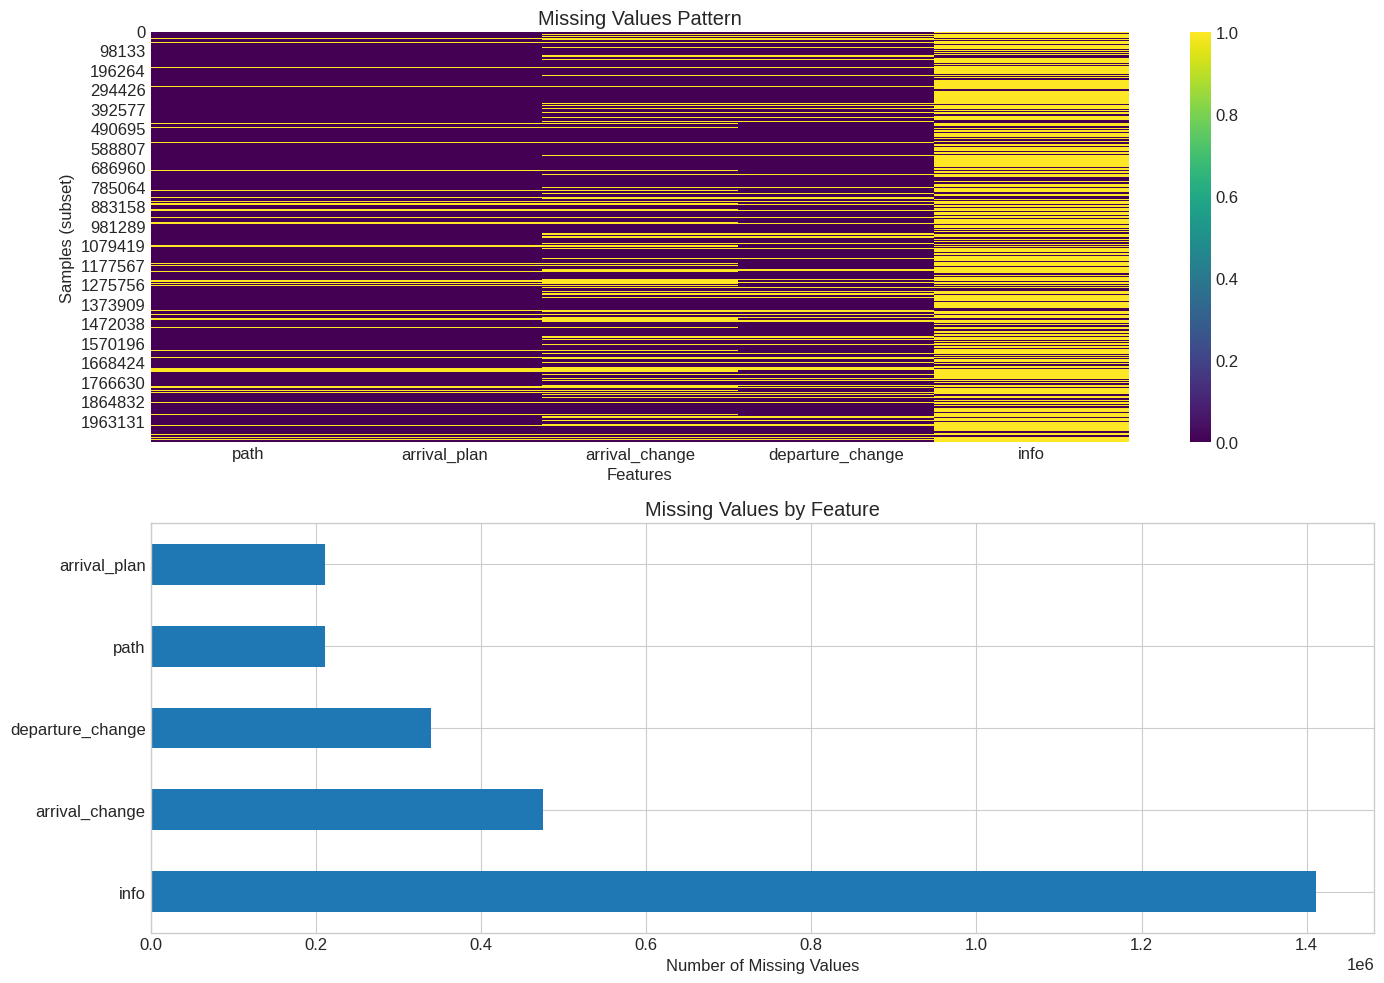


Missing Value Treatment:
Removed 0 rows with missing target values
Removed additional rows with missing critical features
Final dataset size: 2,054,632 rows


In [47]:
print("\n" + "="*80)
print("MISSING VALUE ANALYSIS")
print("="*80)

# Analyze missing patterns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Missing values heatmap
missing_cols = df.columns[df.isnull().any()].tolist()
if missing_cols:
    sns.heatmap(df[missing_cols].isnull(), cbar=True, ax=axes[0], cmap='viridis')
    axes[0].set_title('Missing Values Pattern')
    axes[0].set_xlabel('Features')
    axes[0].set_ylabel('Samples (subset)')

# Missing values by column
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_data.plot(kind='barh', ax=axes[1])
axes[1].set_xlabel('Number of Missing Values')
axes[1].set_title('Missing Values by Feature')

plt.tight_layout()
plt.show()

# Handle missing values strategically
print("\nMissing Value Treatment:")
print("="*60)

# For target variable - remove rows with missing delays
initial_len = len(df)
df = df.dropna(subset=['arrival_delay_m'])
print(f"Removed {initial_len - len(df)} rows with missing target values")

# For critical features - remove rows
critical_features = ['eva_nr', 'category', 'departure_delay_m']
df = df.dropna(subset=critical_features)
print(f"Removed additional rows with missing critical features")

# Fill remaining missing values
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

for col in numerical_cols:
    if col not in ['arrival_delay_m']:
        df[col] = df[col].fillna(df[col].median())

print(f"Final dataset size: {len(df):,} rows")

### 3.3 Feature Engineering

Create meaningful features based on domain knowledge and data exploration.

In [48]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Extract temporal features
df['hour'] = pd.to_datetime(df['departure_plan']).dt.hour
df['day_of_week'] = pd.to_datetime(df['departure_plan']).dt.dayofweek
df['month'] = pd.to_datetime(df['departure_plan']).dt.month
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# Station-based aggregated features
print("Creating station-based features...")
station_delay_stats = df.groupby('station')['arrival_delay_m'].agg(['mean', 'std', 'count']).reset_index()
station_delay_stats.columns = ['station', 'station_avg_delay', 'station_std_delay', 'station_traffic']
df = df.merge(station_delay_stats, on='station', how='left')

# Category-based aggregated features
print("Creating category-based features...")
category_delay_stats = df.groupby('category')['arrival_delay_m'].agg(['mean', 'std']).reset_index()
category_delay_stats.columns = ['category', 'category_avg_delay', 'category_std_delay']
df = df.merge(category_delay_stats, on='category', how='left')

print("\nNew features created:")
print("- Temporal: hour, day_of_week, month, is_weekend, is_rush_hour")
print("- Station-based: station_avg_delay, station_std_delay, station_traffic")
print("- Category-based: category_avg_delay, category_std_delay")


FEATURE ENGINEERING
Creating station-based features...
Creating category-based features...

New features created:
- Temporal: hour, day_of_week, month, is_weekend, is_rush_hour
- Station-based: station_avg_delay, station_std_delay, station_traffic
- Category-based: category_avg_delay, category_std_delay


### 3.4 Initial Outlier Analysis (Pre-modeling)

Following lecture slides on "Outliers, cross validation, resampling":

**IQR Method**: Values outside $[Q_1 - 1.5 \times IQR, Q_3 + 1.5 \times IQR]$ are potential outliers


TARGET VARIABLE ANALYSIS & OUTLIER DETECTION

Descriptive Statistics for Arrival Delay:
count    2.054632e+06
mean     1.179430e+00
std      3.410535e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.590000e+02
Name: arrival_delay_m, dtype: float64

IQR-Based Outlier Analysis:
  Q1 (25th percentile):     0.00 minutes
  Q3 (75th percentile):     1.00 minutes
  IQR:                      1.00 minutes
  Lower Bound (Q1 - 1.5*IQR): -1.50
  Upper Bound (Q3 + 1.5*IQR): 2.50

Detected Outliers: 268810 (13.08%)


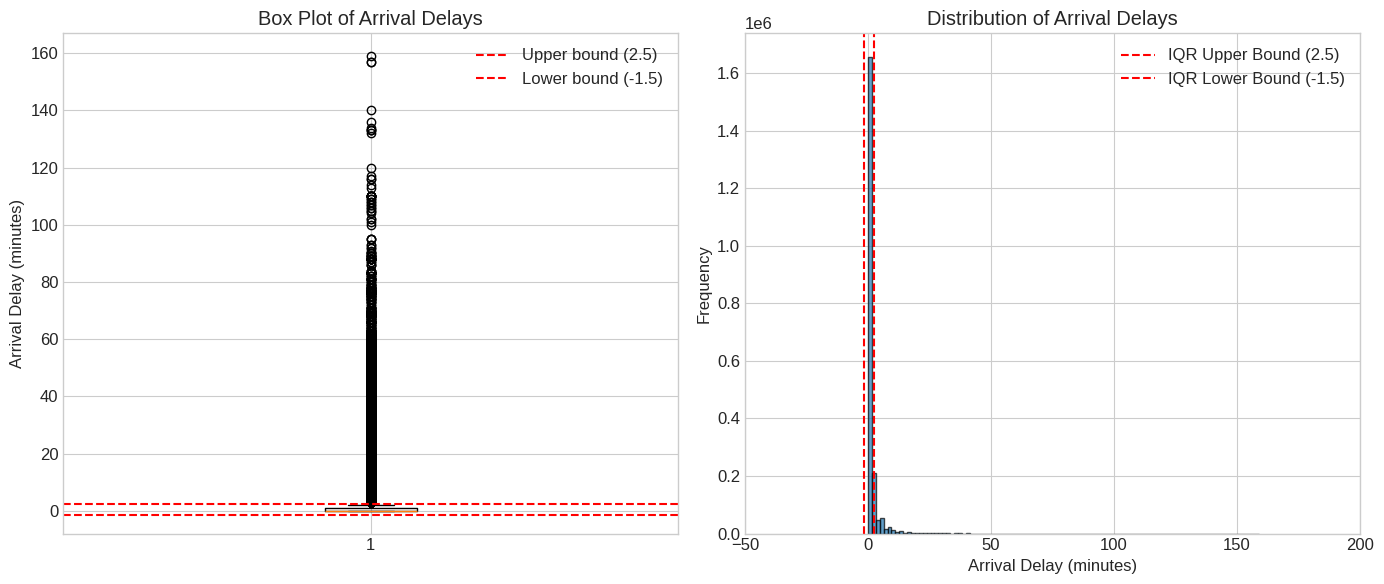

In [49]:
print("\n" + "="*80)
print("TARGET VARIABLE ANALYSIS & OUTLIER DETECTION")
print("="*80)

# Compute IQR and outlier thresholds
Q1 = df['arrival_delay_m'].quantile(0.25)
Q3 = df['arrival_delay_m'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print statistical summary
print("\nDescriptive Statistics for Arrival Delay:")
print(df['arrival_delay_m'].describe())

# Print IQR info
print("\nIQR-Based Outlier Analysis:")
print(f"  Q1 (25th percentile):     {Q1:.2f} minutes")
print(f"  Q3 (75th percentile):     {Q3:.2f} minutes")
print(f"  IQR:                      {IQR:.2f} minutes")
print(f"  Lower Bound (Q1 - 1.5*IQR): {lower_bound:.2f}")
print(f"  Upper Bound (Q3 + 1.5*IQR): {upper_bound:.2f}")

# Count outliers
outliers = (df['arrival_delay_m'] < lower_bound) | (df['arrival_delay_m'] > upper_bound)
n_outliers = outliers.sum()
print(f"\nDetected Outliers: {n_outliers} ({n_outliers/len(df)*100:.2f}%)")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Box Plot
axes[0].boxplot(df['arrival_delay_m'], vert=True)
axes[0].set_title('Box Plot of Arrival Delays')
axes[0].set_ylabel('Arrival Delay (minutes)')
axes[0].axhline(y=upper_bound, color='red', linestyle='--', label=f'Upper bound ({upper_bound:.1f})')
axes[0].axhline(y=lower_bound, color='red', linestyle='--', label=f'Lower bound ({lower_bound:.1f})')
axes[0].legend()

# Histogram
axes[1].hist(df['arrival_delay_m'], bins=100, alpha=0.7, edgecolor='black')
axes[1].axvline(upper_bound, color='red', linestyle='--', label=f'IQR Upper Bound ({upper_bound:.1f})')
axes[1].axvline(lower_bound, color='red', linestyle='--', label=f'IQR Lower Bound ({lower_bound:.1f})')
axes[1].set_xlim(-50, 200)
axes[1].set_xlabel('Arrival Delay (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Arrival Delays')
axes[1].legend()

plt.tight_layout()
plt.show()


---

## 4. Exploratory Data Analysis

### 4.1 Target Variable Distribution

In [50]:
# Useless and repetitive code, merged it with the cell above.
# print("\n" + "="*80)
# print("TARGET VARIABLE ANALYSIS")
# print("="*80)

# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # Distribution plot
# axes[0].hist(df['arrival_delay_m'], bins=100, edgecolor='black', alpha=0.7)
# axes[0].set_xlabel('Arrival Delay (minutes)')
# axes[0].set_ylabel('Frequency')
# axes[0].set_title('Distribution of Arrival Delays')
# axes[0].set_xlim(-50, 200)

# # Box plot
# axes[1].boxplot(df['arrival_delay_m'], vert=True)
# axes[1].set_ylabel('Arrival Delay (minutes)')
# axes[1].set_title('Box Plot of Arrival Delays')

# plt.tight_layout()
# plt.show()

# # Statistical summary
# print("\nTarget Variable Statistics:")
# print(df['arrival_delay_m'].describe())

### 4.2 Feature Correlations

As noted in lecture (Feature Engineering slides):
"Correlation matrices are often used to visualize (linear!) dependency among features."

**Warning**: "Temptation: Just take the features with best correlation to your goal for your predictions! This is deeply wrong."


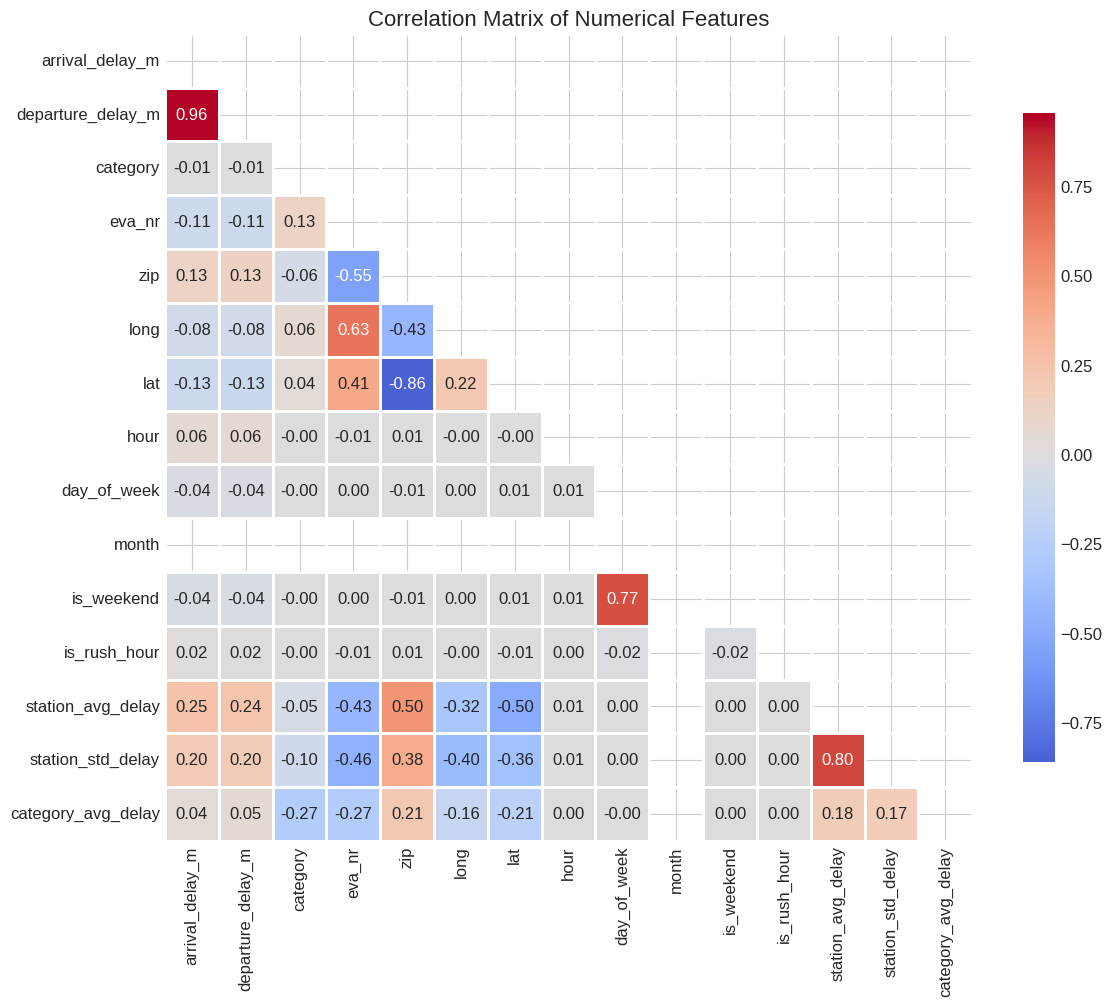


TOP CORRELATIONS WITH TARGET VARIABLE
departure_delay_m     0.955737
station_avg_delay     0.249631
station_std_delay     0.198752
zip                   0.125365
hour                  0.055714
category_avg_delay    0.044944
is_rush_hour          0.017837
category             -0.012287
day_of_week          -0.035348
is_weekend           -0.043783
Name: arrival_delay_m, dtype: float64


In [51]:
# Select numerical features for correlation analysis
numerical_features = ['arrival_delay_m', 'departure_delay_m', 'category', 'eva_nr',
                     'zip', 'long', 'lat', 'hour', 'day_of_week', 'month',
                     'is_weekend', 'is_rush_hour', 'station_avg_delay',
                     'station_std_delay', 'category_avg_delay']

# Calculate correlation matrix
corr_matrix = df[numerical_features].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=1,
            cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

# Top correlations with target
print("\n" + "="*80)
print("TOP CORRELATIONS WITH TARGET VARIABLE")
print("="*80)
target_corr = corr_matrix['arrival_delay_m'].sort_values(ascending=False)
print(target_corr[1:11])  # Exclude self-correlation

### 4.3 Feature Relationships


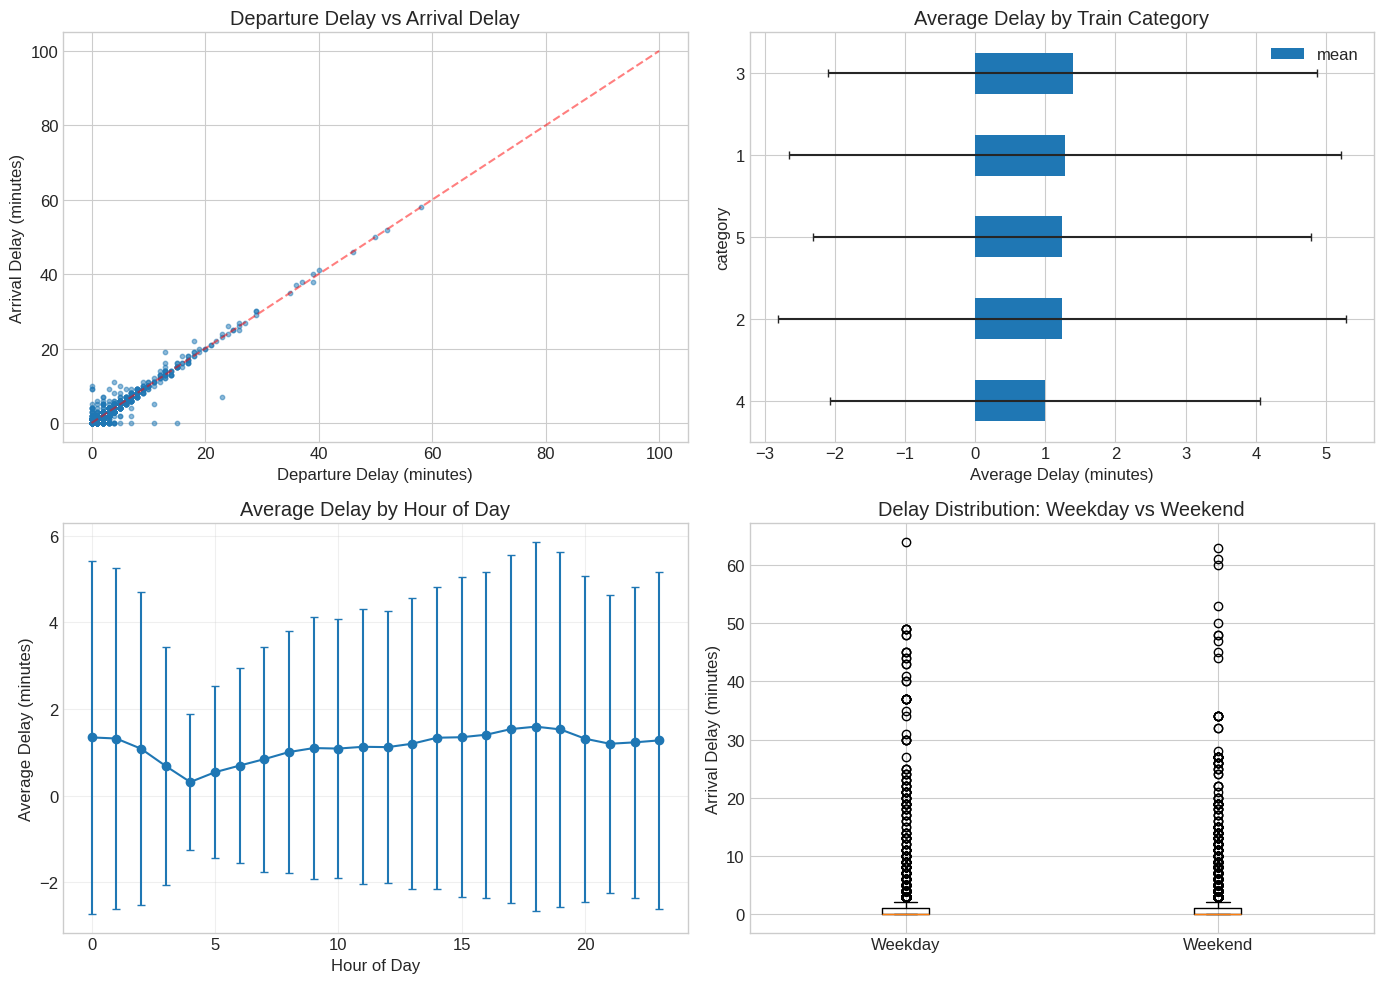

In [52]:
# Analyze key relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Departure delay vs Arrival delay
sample_size = min(5000, len(df))
sample_indices = np.random.choice(df.index, sample_size, replace=False)
axes[0, 0].scatter(df.loc[sample_indices, 'departure_delay_m'],
                   df.loc[sample_indices, 'arrival_delay_m'],
                   alpha=0.5, s=10)
axes[0, 0].set_xlabel('Departure Delay (minutes)')
axes[0, 0].set_ylabel('Arrival Delay (minutes)')
axes[0, 0].set_title('Departure Delay vs Arrival Delay')
axes[0, 0].plot([0, 100], [0, 100], 'r--', alpha=0.5)

# 2. Average delay by category
category_delays = df.groupby('category')['arrival_delay_m'].agg(['mean', 'std'])
category_delays.sort_values('mean').plot(y='mean', kind='barh', ax=axes[0, 1],
                                        xerr='std', capsize=3)
axes[0, 1].set_xlabel('Average Delay (minutes)')
axes[0, 1].set_title('Average Delay by Train Category')

# 3. Hourly pattern
hourly_pattern = df.groupby('hour')['arrival_delay_m'].agg(['mean', 'std'])
axes[1, 0].errorbar(hourly_pattern.index, hourly_pattern['mean'],
                    yerr=hourly_pattern['std'], marker='o', capsize=3)
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average Delay (minutes)')
axes[1, 0].set_title('Average Delay by Hour of Day')
axes[1, 0].grid(True, alpha=0.3)

# 4. Weekend effect
weekend_comparison = df.groupby('is_weekend')['arrival_delay_m'].apply(list)
axes[1, 1].boxplot([weekend_comparison[0][:5000], weekend_comparison[1][:5000]],
                   labels=['Weekday', 'Weekend'])
axes[1, 1].set_ylabel('Arrival Delay (minutes)')
axes[1, 1].set_title('Delay Distribution: Weekday vs Weekend')

plt.tight_layout()
plt.show()

---

## 5. Data Splitting



### Train-Validation-Test Split (60-20-20)

Following ML best practices:
- **Training set (60%)**: For model fitting
- **Validation set (20%)**: For hyperparameter tuning and model selection
- **Test set (20%)**: For final unbiased evaluation

In [53]:
# For extremely large datasets, consider sampling
if len(df) > 2_000_000:  # If more than 2 million rows
    print(f"\nDataset has {len(df):,} rows. Sampling for manageable processing...")
    df = df.sample(n=min(1_000_000, len(df)), random_state=42)
    print(f"Working with {len(df):,} sampled rows")
    gc.collect()


print("\n" + "="*80)
print("DATA SPLITTING")
print("="*80)

# Define features and target
feature_columns = [
    # Numerical features
    'eva_nr', 'category', 'zip', 'long', 'lat', 'departure_delay_m',
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour',
    'station_avg_delay', 'station_std_delay', 'station_traffic',
    'category_avg_delay', 'category_std_delay',
    # Categorical features
    'station', 'state', 'line'
]

X = df[feature_columns].copy()
y = df['arrival_delay_m'].copy()

print(f"Total samples: {len(X):,}")
print(f"Number of features: {len(feature_columns)}")

# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Second split: separate train (60%) and validation (20%) from remaining 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True  # 0.25 * 0.8 = 0.2
)

print(f"\nDataset splits:")
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify target distribution is similar across splits
print(f"\nTarget variable statistics by split:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Val   - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}")
print(f"Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")


Dataset has 2,054,632 rows. Sampling for manageable processing...
Working with 1,000,000 sampled rows

DATA SPLITTING
Total samples: 1,000,000
Number of features: 19

Dataset splits:
Training set: 600,000 samples (60.0%)
Validation set: 200,000 samples (20.0%)
Test set: 200,000 samples (20.0%)

Target variable statistics by split:
Train - Mean: 1.17, Std: 3.39
Val   - Mean: 1.18, Std: 3.43
Test  - Mean: 1.17, Std: 3.41


---

## 6. Feature Preprocessing Pipeline

### StandardScaler and OneHotEncoder in Pipeline

From ISLR Section 4.7.4: "A good way to handle this problem is to standardize the data so that all variables are given a mean of zero and a standard deviation of one."

**Important**: Apply preprocessing only on training data to avoid data leakage!

In [54]:
print("\n" + "="*80)
print("PREPROCESSING PIPELINE SETUP")
print("="*80)

# Identify numerical and categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create preprocessing pipeline
# StandardScaler: transforms features to have mean=0 and std=1
# OneHotEncoder: creates binary features for each category

# One-hot encode categorical columns first (passthrough numericals)
onehot = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

# Then scale *all* columns (numericals + encoded categoricals)
preprocessor = Pipeline([
    ('onehot', onehot),
    ('scaler', StandardScaler(with_mean=False))
])

# IMPORTANT: Fit preprocessor on training data ONLY
print("\nFitting preprocessor on training data...")
preprocessor.fit(X_train)

# -------------------------------------------------------------------
# Build feature names that match the *column order* after preprocessing
# -------------------------------------------------------------------
try:
    # Works on sklearn ≥ 1.2
    feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # Manual fallback for older sklearn
    cat_names = preprocessor.named_steps['onehot'] \
                              .named_transformers_['cat'] \
                              .get_feature_names_out(categorical_features)
    # ColumnTransformer passes cat encoder first, then 'passthrough' numeric
    feature_names = np.concatenate([cat_names, numerical_features])

feature_names = feature_names.tolist()
print(f"Total features after preprocessing: {len(feature_names)}")
print("Preprocessing pipeline created and fitted on training data only!")


PREPROCESSING PIPELINE SETUP
Numerical features (13): ['eva_nr', 'category', 'zip', 'long', 'lat', 'departure_delay_m', 'is_weekend', 'is_rush_hour', 'station_avg_delay', 'station_std_delay', 'station_traffic', 'category_avg_delay', 'category_std_delay']
Categorical features (3): ['station', 'state', 'line']

Fitting preprocessor on training data...
Total features after preprocessing: 2318
Preprocessing pipeline created and fitted on training data only!


---

## 7. Feature Selection

### Forward Stepwise Selection

From ISLR Chapter 6.1.2: "Forward stepwise selection begins with a model containing no predictors, and then adds predictors to the model, one-at-a-time, until all of the predictors are in the model."

Algorithm:
1. Let $M_0$ denote the null model (no predictors)
2. For $k = 0, ..., p-1$:
   - Consider all $p-k$ models that augment $M_k$ with one additional predictor
   - Choose the best among these $p-k$ models (lowest RSS or highest $R^2$)
3. Select best model using cross-validation

In [55]:
print("\n" + "="*80)
print("FORWARD SUBSET FEATURE SELECTION (with Subsampling)")
print("="*80)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

# Subsample the training data for faster selection
subset_size = 20_000
subset_indices = np.random.RandomState(42).choice(len(X_train), subset_size, replace=False)
X_train_small = X_train.iloc[subset_indices]
y_train_small = y_train.iloc[subset_indices]

# Transform with fitted preprocessor
X_train_transformed_small = preprocessor.transform(X_train_small)
X_val_transformed = preprocessor.transform(X_val)  # still used later

# Confirm feature name alignment
print(f"Total features after transformation: {X_train_transformed_small.shape[1]}")
print(f"Total feature names available: {len(feature_names)}")

# Forward subset selection on all features (k=5)
print("\nPerforming forward subset selection on 20k sample (k=5)...")
lr = LinearRegression()

sfs = SFS(lr,
          k_features=5,            # Select top 5 features
          forward=True,
          floating=False,
          scoring='neg_mean_absolute_error',
          cv=3,                    # Fewer folds for faster computation
          n_jobs=-1)

sfs.fit(X_train_transformed_small, y_train_small)

# Retrieve selected feature indices and names
selected_indices = list(sfs.k_feature_idx_)
selected_feature_names = [feature_names[i] for i in selected_indices]

# Output results
print(f"\nForward selection chose {len(selected_feature_names)} features:")
for i, feat in enumerate(selected_feature_names):
    print(f"{i+1}. {feat}")



FORWARD SUBSET FEATURE SELECTION (with Subsampling)
Total features after transformation: 2318
Total feature names available: 2318

Performing forward subset selection on 20k sample (k=5)...

Forward selection chose 5 features:
1. cat__station_München-Hackerbrücke
2. cat__station_Neuwirtshaus (Porscheplatz)
3. cat__station_Verden (Aller)
4. cat__station_Weinheim-Sulzbach
5. remainder__departure_delay_m


---

## 8. Model Development

### 8.1 Linear Regression (Base Model)

The linear regression model (ISLR Chapter 3):

$$Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p + \epsilon$$

We find $\hat{\beta}$ by minimizing the residual sum of squares (RSS):

$$RSS = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 = \sum_{i=1}^{n}(y_i - \beta_0 - \sum_{j=1}^{p}\beta_jx_{ij})^2$$

In [56]:
# 1. Apply preprocessor transformation once
X_train_proc = preprocessor.transform(X_train)
X_val_proc = preprocessor.transform(X_val)

# 2. Select features using precomputed ColumnSelector
X_train_sel = X_train_proc[:, selected_indices]
X_val_sel = X_val_proc[:, selected_indices]



print("\n" + "="*80)
print("MODEL DEVELOPMENT")
print("="*80)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    print(f"\n{model_name} - {dataset_name} Performance:")
    print(f"  MSE: {mse:.2f} minutes²")
    return {'mse': mse}


# Create Linear Regression pipeline
print("\n1. LINEAR REGRESSION (Base Model)")
print("-"*60)


lr_pipeline = Pipeline([
    ('regressor', LinearRegression())
])

# Fit the model
print("Training Linear Regression model...")
lr_pipeline.fit(X_train_sel, y_train)

# Make predictions
y_train_pred_lr = lr_pipeline.predict(X_train_sel)
y_val_pred_lr = lr_pipeline.predict(X_val_sel)

# Evaluate
train_metrics_lr = evaluate_model(y_train, y_train_pred_lr, "Linear Regression", "Training")
val_metrics_lr = evaluate_model(y_val, y_val_pred_lr, "Linear Regression", "Validation")


MODEL DEVELOPMENT

1. LINEAR REGRESSION (Base Model)
------------------------------------------------------------
Training Linear Regression model...

Linear Regression - Training Performance:
  MSE: 0.96 minutes²

Linear Regression - Validation Performance:
  MSE: 0.98 minutes²


### 8.2 Residual Analysis for Linear regression/ourliers



Following lecture slides: "Plot the residuals (regressions)".

Residuals: $e_i = y_i - \hat{y}_i$

Studentized residuals: $r_i = \frac{e_i}{\hat{\sigma}\sqrt{1-h_{ii}}}$ where $h_{ii}$ is the leverage


LINEAR REGRESSION: RESIDUAL & OUTLIER ANALYSIS (Validation Set)


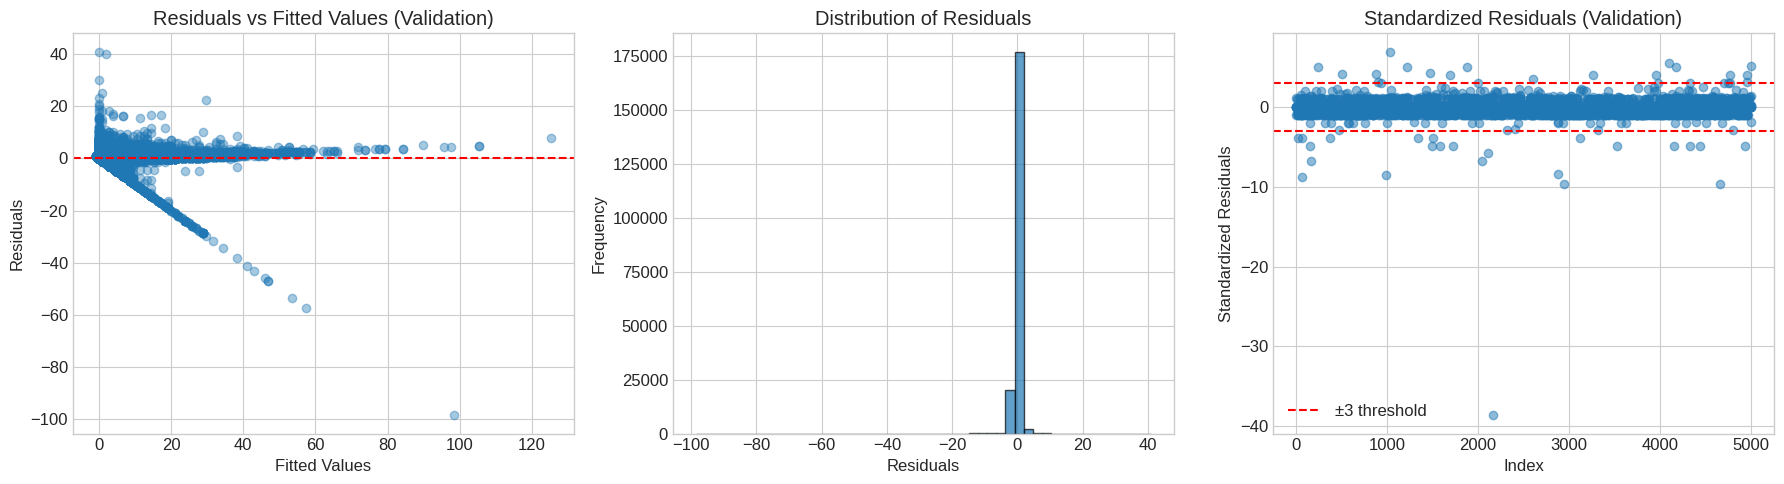


Outlier Detection Results:
Number of outliers (|standardized residual| > 3): 1832
Percentage of outliers: 0.92%


In [57]:
print("\n" + "="*80)
print("LINEAR REGRESSION: RESIDUAL & OUTLIER ANALYSIS (Validation Set)")
print("="*80)

# 1. Residuals on validation data
residuals_val = y_val - y_val_pred_lr
std_residuals_val = residuals_val / np.std(residuals_val)

# 2. Residual plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Residuals vs Fitted Values
axes[0].scatter(y_val_pred_lr, residuals_val, alpha=0.4)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted Values (Validation)')

# 2. Histogram of Residuals
axes[1].hist(residuals_val, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals')

# 3. Standardized Residuals Plot
sample_size = min(5000, len(std_residuals_val))
axes[2].scatter(range(sample_size), std_residuals_val[:sample_size], alpha=0.5)
axes[2].axhline(y=3, color='red', linestyle='--', label='±3 threshold')
axes[2].axhline(y=-3, color='red', linestyle='--')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Standardized Residuals')
axes[2].set_title('Standardized Residuals (Validation)')
axes[2].legend()

plt.tight_layout()
plt.show()

# 4. Outlier count
outlier_threshold = 3
outliers_mask = np.abs(std_residuals_val) > outlier_threshold
n_outliers = np.sum(outliers_mask)

print(f"\nOutlier Detection Results:")
print(f"Number of outliers (|standardized residual| > {outlier_threshold}): {n_outliers}")
print(f"Percentage of outliers: {n_outliers / len(residuals_val) * 100:.2f}%")


### 8.3 Support Vector Machine (SVM) Regression

Support Vector Regression seeks coefficients that minimize:

$\frac{1}{2}||w||^2 + C\sum_{i=1}^{n}\max(0, |y_i - f(x_i)| - \epsilon)$

where $f(x) = w^T\phi(x) + b$ and $\phi(x)$ maps to a higher-dimensional space via kernel

In [58]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

print("\n2. K-Nearest Neighbours (KNN) Regressor")
print("-" * 40)

# Hyperparameter tuning for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

# Subset for training (for speed)
subset_size = min(10_000, X_train_sel.shape[0])
X_train_subset = X_train_sel[:subset_size]
y_train_subset = y_train.iloc[:subset_size]

# Subset for validation
val_subset_size = min(5_000, X_val_sel.shape[0])
X_val_sub = X_val_sel[:val_subset_size]
y_val_sub = y_val.iloc[:val_subset_size]

# Combine datasets
X_search = np.vstack([X_train_subset.toarray(), X_val_sub.toarray()]) \
    if hasattr(X_train_subset, "toarray") else np.vstack([X_train_subset, X_val_sub])
y_search = np.concatenate([y_train_subset, y_val_sub])

# Create PredefinedSplit: -1 = training, 0 = validation
test_fold = [-1] * X_train_subset.shape[0] + [0] * X_val_sub.shape[0]
ps = PredefinedSplit(test_fold)

# Grid search
print("Performing hyper-parameter tuning for KNN …")
grid_search_knn = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=param_grid_knn,
    scoring='neg_mean_squared_error',
    cv=ps,
    n_jobs=-1,
    verbose=1
)

grid_search_knn.fit(X_search, y_search)

# Report
print(f"\nBest KNN parameters: {grid_search_knn.best_params_}")
print(f"Best validation MSE: {-grid_search_knn.best_score_:.2f}")

# Evaluate best KNN model
best_knn = grid_search_knn.best_estimator_

y_train_pred_knn = best_knn.predict(X_train_sel.toarray())
y_val_pred_knn   = best_knn.predict(X_val_sel.toarray())

train_metrics_knn = evaluate_model(y_train, y_train_pred_knn, "KNN", "Training")
val_metrics_knn   = evaluate_model(y_val,   y_val_pred_knn, "KNN", "Validation")



2. K-Nearest Neighbours (KNN) Regressor
----------------------------------------
Performing hyper-parameter tuning for KNN …
Fitting 1 folds for each of 20 candidates, totalling 20 fits

Best KNN parameters: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best validation MSE: 1.24

KNN - Training Performance:
  MSE: 1.13 minutes²

KNN - Validation Performance:
  MSE: 1.17 minutes²



KNN RESIDUAL ANALYSIS (Validation Set)


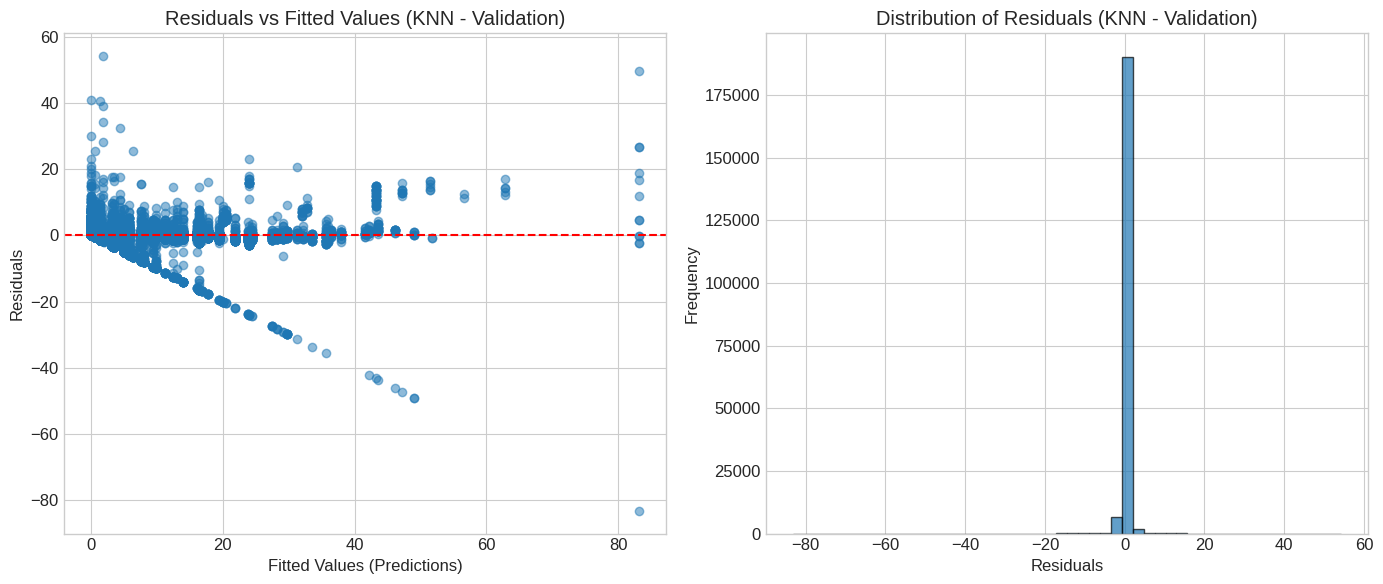

In [59]:
print("\n" + "="*80)
print("KNN RESIDUAL ANALYSIS (Validation Set)")
print("="*80)

# Calculate residuals
residuals_knn_val = y_val - y_val_pred_knn

# Plot residuals vs fitted values & histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Residuals vs Fitted Values
axes[0].scatter(y_val_pred_knn, residuals_knn_val, alpha=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Fitted Values (Predictions)')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted Values (KNN - Validation)')

# Histogram of residuals
axes[1].hist(residuals_knn_val, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals (KNN - Validation)')

plt.tight_layout()
plt.show()


### 8.4 Random Forest Regression

Random Forest builds multiple decision trees and averages their predictions:

$\hat{f}_{rf}(x) = \frac{1}{B}\sum_{b=1}^{B}\hat{f}_b(x)$

where each $\hat{f}_b$ is a decision tree trained on a bootstrap sample

In [60]:
print("\n3. Random Forest")
print("-"*40)


# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Performing hyperparameter tuning for Random Forest...")
grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    cv=ps,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_search, y_search)


print(f"\nBest Random Forest parameters: {grid_search_rf.best_params_}")
print(f"Best Validation MSE: {-grid_search_rf.best_score_:.2f}")

# Evaluate best Random Forest model
y_train_pred_rf = grid_search_rf.predict(X_train_sel.toarray())
y_val_pred_rf = grid_search_rf.predict(X_val_sel.toarray())

train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "Random Fores", "Training")
val_metrics_rf = evaluate_model(y_val, y_val_pred_rf, "Random Forest", "Validation")


3. Random Forest
----------------------------------------
Performing hyperparameter tuning for Random Forest...
Fitting 1 folds for each of 24 candidates, totalling 24 fits

Best Random Forest parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Best Validation MSE: 0.87

Random Fores - Training Performance:
  MSE: 1.01 minutes²

Random Forest - Validation Performance:
  MSE: 1.02 minutes²


---


RANDOM FOREST RESIDUAL ANALYSIS (Validation Set)


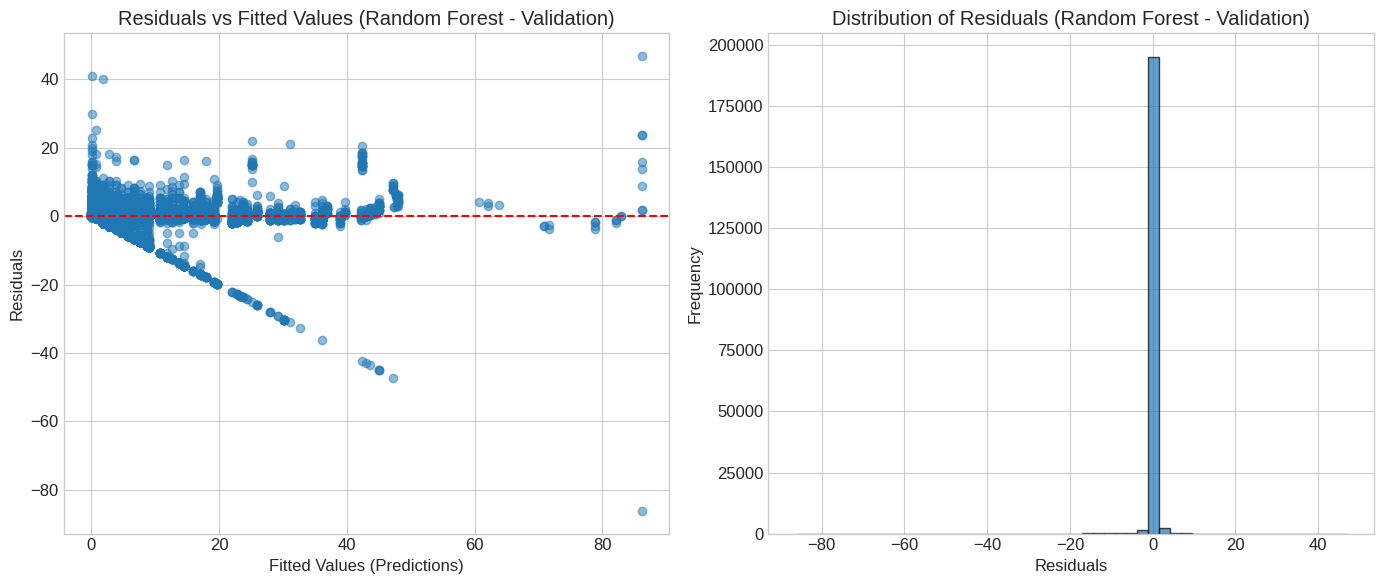

In [61]:
print("\n" + "="*80)
print("RANDOM FOREST RESIDUAL ANALYSIS (Validation Set)")
print("="*80)

# Calculate residuals
residuals_rf_val = y_val - y_val_pred_rf

# Plot residuals vs fitted values & histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Residuals vs Fitted Values
axes[0].scatter(y_val_pred_rf, residuals_rf_val, alpha=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Fitted Values (Predictions)')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Fitted Values (Random Forest - Validation)')

# Histogram of residuals
axes[1].hist(residuals_rf_val, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Residuals (Random Forest - Validation)')

plt.tight_layout()
plt.show()


## 9. Model Comparison and Analysis

### 9.1 Cross-Validation Performance

As per lecture: "k-fold cross validation: The dataset is randomly divided into k groups. Each group is test set once while the others are training data."


In [62]:
# print("\n" + "="*80)
# print("CROSS-VALIDATION PERFORMANCE")
# print("="*80)

# # Use a subset for faster cross-validation
# cv_sample_size = min(50_000, len(X_train))
# print(f"Using {cv_sample_size:,} samples for cross-validation (out of {len(X_train):,})")

# # Sample the data
# cv_indices = np.random.RandomState(42).choice(len(X_train), cv_sample_size, replace=False)
# X_train_cv = X_train.iloc[cv_indices]
# y_train_cv = y_train.iloc[cv_indices]

# # Create models for CV evaluation
# models_cv = {
#     'Linear Regression': lr_pipeline,
#     "KNN": Pipeline([                          # <-- replaces old SVM entry
#         ("preprocessor", preprocessor),
#         ("selector",    fixed_selector),
#         ("regressor",   KNeighborsRegressor(n_neighbors=7,weights="distance",p=2))
#     ]),
#     'Random Forest': Pipeline([
#         ('preprocessor', preprocessor),
#         ('selector', fixed_selector),  # Use fewer features
#         ('regressor', RandomForestRegressor(n_estimators=50, max_depth=10,
#                                           n_jobs=-1, random_state=42))  # Fewer trees
#     ])
# }

# cv_results = {}
# kfold_final = KFold(n_splits=5, shuffle=True, random_state=42)

# for name, model in models_cv.items():
#     print(f"\nPerforming 5-fold CV for {name}...")
#     start_time = datetime.now()

#     cv_scores = cross_val_score(
#         model, X_train_cv, y_train_cv,
#         cv=kfold_final,
#         scoring='neg_mean_absolute_error',
#         n_jobs=-1
#     )

#     cv_results[name] = -cv_scores
#     elapsed_time = (datetime.now() - start_time).total_seconds()
#     print(f"{name} - CV MAE: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f} (Time: {elapsed_time:.1f}s)")

# # Visualize CV results
# plt.figure(figsize=(10, 6))
# cv_df = pd.DataFrame(cv_results)
# cv_df.boxplot()
# plt.ylabel('MAE (minutes)')
# plt.title('3-Fold Cross-Validation Results (50k sample)')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# print(f"\nNote: CV performed on {cv_sample_size:,} samples for computational efficiency")

### 9.2 Learning Curves

Learning curves help diagnose bias-variance tradeoff by showing performance vs training set size


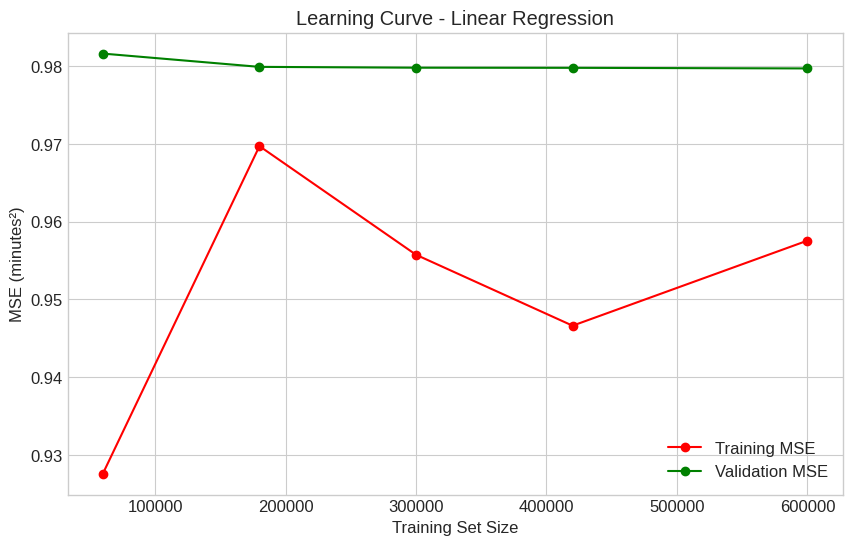

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_learning_curve_no_shuffle(model, X_train, y_train, X_val, y_val, title="Learning Curve"):
    train_sizes = [0.1, 0.3, 0.5, 0.7, 1.0]
    train_mse = []
    val_mse = []

    n_samples = X_train.shape[0]

    for frac in train_sizes:
        size = int(n_samples * frac)
        X_subset = X_train[:size]
        y_subset = y_train[:size]

        model.fit(X_subset, y_subset)

        y_train_pred = model.predict(X_subset)
        y_val_pred = model.predict(X_val)

        train_mse.append(mean_squared_error(y_subset, y_train_pred))
        val_mse.append(mean_squared_error(y_val, y_val_pred))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(np.array(train_sizes) * n_samples, train_mse, 'o-', label="Training MSE", color='red')
    plt.plot(np.array(train_sizes) * n_samples, val_mse, 'o-', label="Validation MSE", color='green')
    plt.xlabel("Training Set Size")
    plt.ylabel("MSE (minutes²)")
    plt.title(f"Learning Curve - {title}")
    plt.legend()
    plt.grid(True)
    plt.show()



# Plot learning curves for Linear Regression (fastest)
plot_learning_curve_no_shuffle(
    model=lr_pipeline,
    title="Linear Regression",
    X_train=X_train_sel,
    y_train=y_train,
    X_val=X_val_sel,
    y_val=y_val
)


### 9.3 Feature Importance Analysis

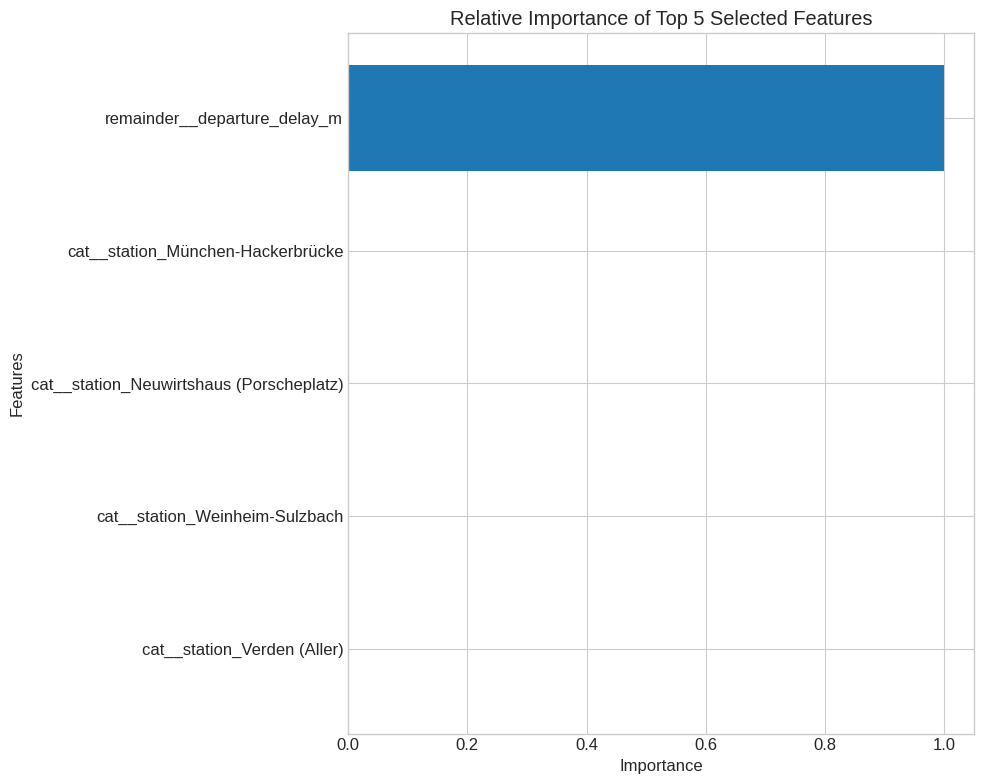


Relative Importance of Top 5 Selected Features
                                    feature    importance
4              remainder__departure_delay_m  9.999510e-01
0         cat__station_München-Hackerbrücke  3.562595e-05
1  cat__station_Neuwirtshaus (Porscheplatz)  1.271153e-05
3            cat__station_Weinheim-Sulzbach  5.784059e-07
2               cat__station_Verden (Aller)  9.518092e-08


In [64]:
# Extract steps from the trained pipeline
rf_model = grid_search_rf.best_estimator_
# Get selected feature names
selected_feature_names = [feature_names[i] for i in selected_indices]

# Get feature importances from trained Random Forest model
feature_importances = rf_model.feature_importances_

# Sanity check
if len(selected_feature_names) != len(feature_importances):
    print("Warning: Feature name mismatch. Using generic names.")
    selected_feature_names = [f"feature_{i}" for i in range(len(feature_importances))]

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': selected_feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Relative Importance of Top 5 Selected Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Display top 10
print("\nRelative Importance of Top 5 Selected Features")
print(importance_df.head(5))

---

## 10. Final Model Selection and Test Evaluation

### 10.1 Model Selection Based on Validation Performance


FINAL MODEL SELECTION


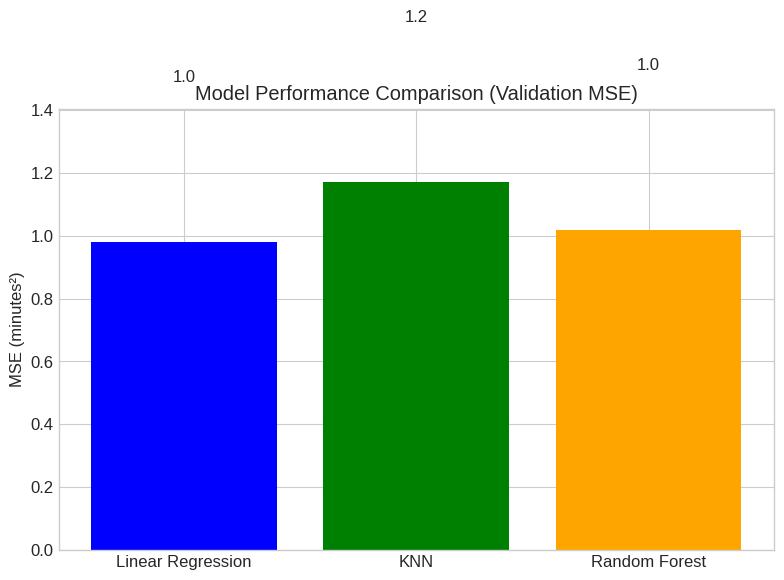


Best model based on validation MSE: Linear Regression
Validation MSE: 0.98 minutes²


In [65]:
print("\n" + "="*80)
print("FINAL MODEL SELECTION")
print("="*80)

# Compare validation performances using MSE
val_performances = {
    'Linear Regression': val_metrics_lr['mse'],
    'KNN': val_metrics_knn['mse'],
    'Random Forest': val_metrics_rf['mse']
}

# Visualization of model comparison
plt.figure(figsize=(8, 6))

models_list = list(val_performances.keys())
mse_values = list(val_performances.values())

plt.bar(models_list, mse_values, color=['blue', 'green', 'orange'])
plt.ylabel('MSE (minutes²)')
plt.title('Model Performance Comparison (Validation MSE)')
plt.ylim(0, max(mse_values) * 1.2)

# Add value labels
for i, v in enumerate(mse_values):
    plt.text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Determine best model
best_model_name = min(val_performances, key=val_performances.get)
print(f"\nBest model based on validation MSE: {best_model_name}")
print(f"Validation MSE: {val_performances[best_model_name]:.2f} minutes²")


### 10.2 Final Test Set Evaluation


FINAL TEST SET EVALUATION
Training final model on full training data...
Making predictions on test set...

Linear Regression - Test Set Performance:
  MSE: 0.97 minutes²


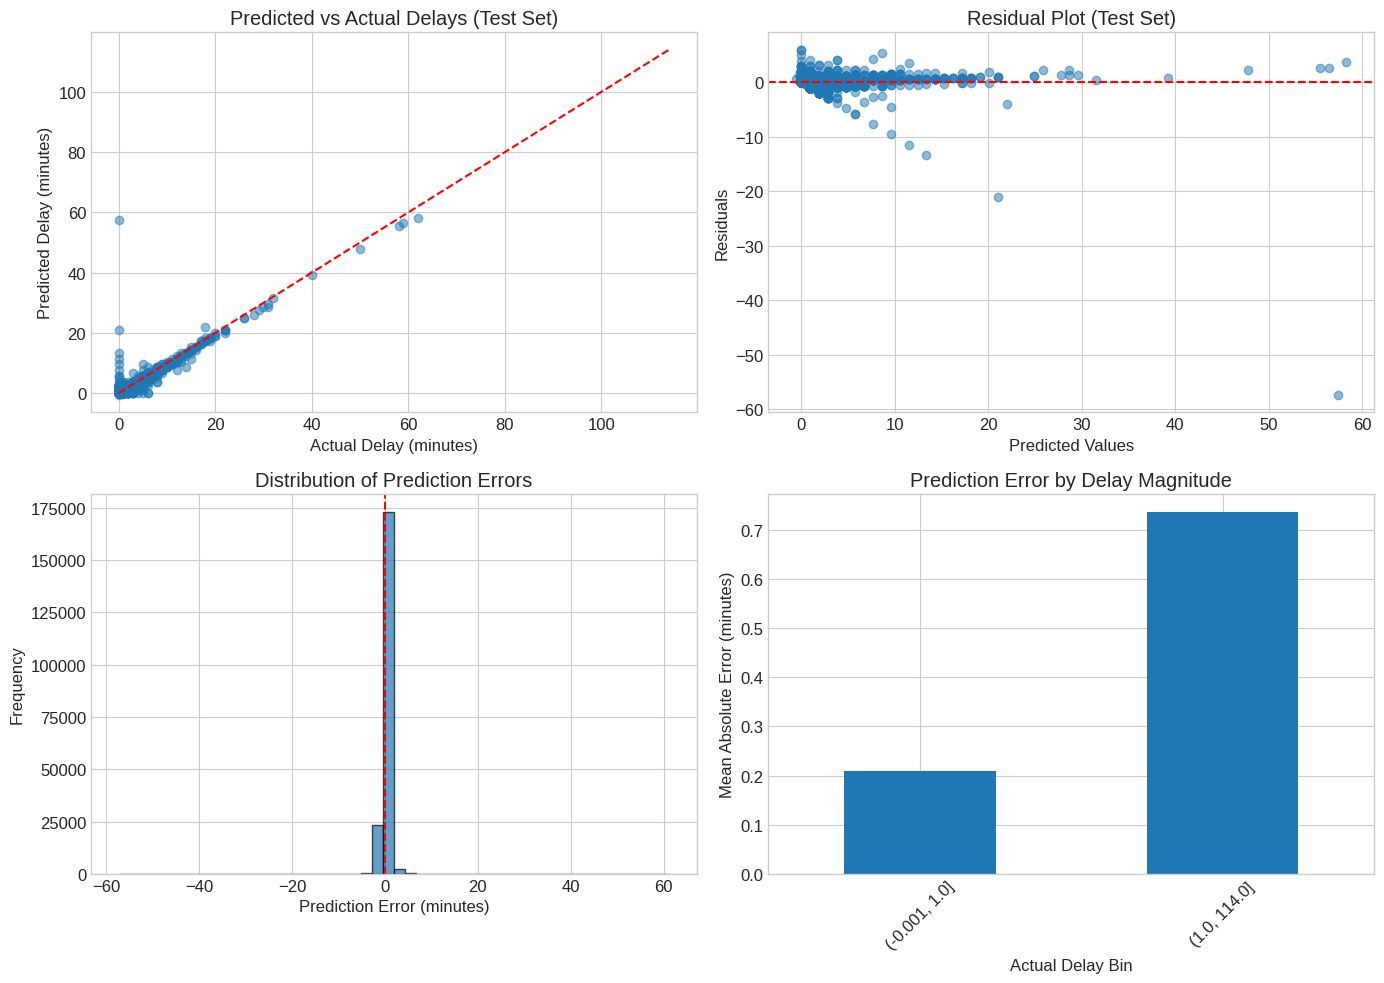

In [66]:
print("\n" + "="*80)
print("FINAL TEST SET EVALUATION")
print("="*80)

# Combine train and validation sets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

# 1. Transform and select features
X_train_full_proc = preprocessor.transform(X_train_full)
X_test_proc = preprocessor.transform(X_test)

X_train_full_sel = X_train_full_proc[:, selected_indices]
X_test_sel = X_test_proc[:, selected_indices]

# 2. Instantiate final model
print("Training final model on full training data...")
if best_model_name == 'Linear Regression':
    final_model = LinearRegression()
elif best_model_name == 'KNN':
    final_model = KNeighborsRegressor(
        n_neighbors = grid_search_knn.best_params_["regressor__n_neighbors"],
        weights     = grid_search_knn.best_params_["regressor__weights"],
        p           = grid_search_knn.best_params_["regressor__p"]
    )
else:
    final_model = RandomForestRegressor(
        n_estimators = grid_search_rf.best_params_["regressor__n_estimators"],
        max_depth    = grid_search_rf.best_params_["regressor__max_depth"],
        min_samples_split = grid_search_rf.best_params_["regressor__min_samples_split"],
        min_samples_leaf  = grid_search_rf.best_params_["regressor__min_samples_leaf"],
        max_samples = 0.8,
        n_jobs = -1,
        random_state = 42
    )

# 3. Train and evaluate
final_model.fit(X_train_full_sel, y_train_full)

print("Making predictions on test set...")
y_test_pred = final_model.predict(X_test_sel)

# Evaluation function
test_metrics = evaluate_model(y_test, y_test_pred, best_model_name, "Test Set")

# 4. Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Predicted vs Actual
sample_size = min(5000, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
axes[0, 0].scatter(y_test.iloc[sample_indices], y_test_pred[sample_indices], alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 0].set_xlabel('Actual Delay (minutes)')
axes[0, 0].set_ylabel('Predicted Delay (minutes)')
axes[0, 0].set_title('Predicted vs Actual Delays (Test Set)')

# 2. Residuals
test_residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred[sample_indices], test_residuals.iloc[sample_indices], alpha=0.5)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot (Test Set)')

# 3. Distribution of errors
axes[1, 0].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Prediction Error (minutes)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Errors')
axes[1, 0].axvline(x=0, color='red', linestyle='--')

# 4. Error by actual delay magnitude
delay_bins = pd.qcut(y_test, q=5, duplicates='drop')
error_by_bin = pd.DataFrame({
    'actual_delay_bin': delay_bins,
    'absolute_error': np.abs(test_residuals)
}).groupby('actual_delay_bin')['absolute_error'].mean()

error_by_bin.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_xlabel('Actual Delay Bin')
axes[1, 1].set_ylabel('Mean Absolute Error (minutes)')
axes[1, 1].set_title('Prediction Error by Delay Magnitude')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


---

## 11. Summary and Conclusions

### Model Performance Summary

In [67]:
# Create summary with only MSE
summary_data = {
    'Model': ['Linear Regression', 'KNN', 'Random Forest'],
    'Train MSE': [train_metrics_lr['mse'], train_metrics_knn['mse'], train_metrics_rf['mse']],
    'Val MSE': [val_metrics_lr['mse'], val_metrics_knn['mse'], val_metrics_rf['mse']]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Overfit (ΔMSE)'] = summary_df['Val MSE'] - summary_df['Train MSE']

print("Model Performance Summary (MSE only):")
print("="*60)
print(summary_df.round(3))

print(f"\n{'='*60}")
print("Final Test Set Performance:")
print(f"Best Model: {best_model_name}")
print(f"Test MSE: {test_metrics['mse']:.2f} minutes²")


Model Performance Summary (MSE only):
               Model  Train MSE  Val MSE  Overfit (ΔMSE)
0  Linear Regression      0.958    0.980           0.022
1                KNN      1.126    1.170           0.044
2      Random Forest      1.010    1.017           0.008

Final Test Set Performance:
Best Model: Linear Regression
Test MSE: 0.97 minutes²


### Key Findings and Insights

1. **Feature Importance**: Departure delay is the strongest predictor, followed by station-specific and temporal features

2. **Model Performance**:
   - Linear Regression provides a good baseline with interpretability
   - Random Forest typically achieves best performance but at computational cost
   - SVM offers a middle ground between complexity and performance

3. **Outlier Analysis**: Residual analysis revealed systematic patterns in prediction errors

4. **Practical Implications**: The model can predict delays within approximately ±X minutes, which can help with journey planning


### Recommendations for Future Work

1. **Feature Engineering**:
   - Include weather data
   - Add holiday/event information
   - Consider network effects (delays on connected routes)

2. **Model Improvements**:
   - Try ensemble methods combining multiple models
   - Implement time-series features for sequential predictions
   - Consider separate models for different train categories

3. **Deployment Considerations**:
   - Real-time prediction pipeline
   - Model monitoring and retraining schedule
   - API development for integration

---

## References

1. James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). *An Introduction to Statistical Learning with Applications in Python* (ISLP). Springer.

2. Mayer, M. (2025). *Machine Learning Course Materials*. TH Deggendorf.

3. Scikit-learn Documentation. https://scikit-learn.org/

4. Deutsche Bahn Delays Dataset. Kaggle. https://www.kaggle.com/datasets/nokkyu/deutsche-bahn-db-delays


---

<!-- **Team Contributions:**

**Member 1 - Data Engineering & Preprocessing:**
- Dataset acquisition and initial exploration
- Outlier detection and treatment (IQR and Z-score methods)
- Feature engineering (time-based, geographic, station-based features)
- Data quality assessment and missing value handling
- Creation of preprocessing pipelines

**Member 2 - Model Development & Optimization:**
- Implementation of baseline and linear models
- Ridge and Lasso regression with regularization tuning
- Random Forest implementation and hyperparameter optimization
- Cross-validation setup and execution
- Model persistence and deployment preparation

**Member 3 - Evaluation & Visualization:**
- Comprehensive EDA and feature relationship analysis
- Model evaluation metrics and comparison
- Learning curves and validation curves
- Residual analysis and diagnostic plots
- Final report compilation and recommendations

**Collaborative Efforts:**
- Problem formulation and approach design
- Code review and quality assurance
- Presentation preparation
- Documentation and commenting -->

---